In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.base import clone



from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve
)

In [37]:
def evaluate_binary_model_cv(
    model,
    X,
    y,
    n_splits=5,
    random_state=42,
    plot_curves=True,
    verbose=True,
):
    """
    Evaluate a binary classifier using stratified K-fold CV.
    Computes GLOBAL confusion matrix + GLOBAL ROC/PR curves.
    """

    X = np.asarray(X)
    y = np.asarray(y)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    metrics_per_fold = {
        "accuracy": [],
        "balanced_accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "roc_auc": [],
        "pr_auc": [],
    }

    # GLOBAL storage
    all_y_true = []
    all_y_pred = []
    all_y_score = []

    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = clone(model)
        clf.fit(X_train, y_train)

        # Discrete predictions
        y_pred = clf.predict(X_test)

        # Probabilities or decision function
        if hasattr(clf, "predict_proba"):
            y_score = clf.predict_proba(X_test)[:, 1]
        elif hasattr(clf, "decision_function"):
            y_score = clf.decision_function(X_test)
        else:
            y_score = None

        # Standard metrics
        acc = accuracy_score(y_test, y_pred)
        bacc = balanced_accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        metrics_per_fold["accuracy"].append(acc)
        metrics_per_fold["balanced_accuracy"].append(bacc)
        metrics_per_fold["precision"].append(prec)
        metrics_per_fold["recall"].append(rec)
        metrics_per_fold["f1"].append(f1)

        # AUC metrics
        if y_score is not None and len(np.unique(y_test)) == 2:
            try:
                roc = roc_auc_score(y_test, y_score)
                pr = average_precision_score(y_test, y_score)
            except ValueError:
                roc, pr = np.nan, np.nan
        else:
            roc, pr = np.nan, np.nan

        metrics_per_fold["roc_auc"].append(roc)
        metrics_per_fold["pr_auc"].append(pr)

        # Store GLOBAL predictions
        all_y_true.append(y_test)
        all_y_pred.append(y_pred)
        if y_score is not None:
            all_y_score.append(y_score)

        if verbose:
            print(f"\nFold {fold_idx}/{n_splits}")
            print(f"  Accuracy:           {acc:.3f}")
            print(f"  Balanced accuracy:  {bacc:.3f}")
            print(f"  Precision:          {prec:.3f}")
            print(f"  Recall:             {rec:.3f}")
            print(f"  F1-score:           {f1:.3f}")
            if not np.isnan(roc):
                print(f"  ROC AUC:            {roc:.3f}")
                print(f"  PR AUC (AvgPrec):   {pr:.3f}")

    # Concatenate all folds
    all_y_true = np.concatenate(all_y_true)
    all_y_pred = np.concatenate(all_y_pred)
    all_y_score = np.concatenate(all_y_score) if len(all_y_score) > 0 else None

    # Compute mean and std of metrics
    results = {}
    for m, vals in metrics_per_fold.items():
        vals = np.array(vals, dtype=float)
        results[m + "_per_fold"] = vals
        results[m + "_mean"] = np.nanmean(vals)
        results[m + "_std"] = np.nanstd(vals)

    if verbose:
        print("\nMean CV metrics across folds")
        for m in ["accuracy", "balanced_accuracy", "precision", "recall", "f1", "roc_auc", "pr_auc"]:
            print(f"{m:18s}: {results[m + '_mean']:.3f} ± {results[m + '_std']:.3f}")

    # GLOBAL confusion matrix
    if verbose:
        print("\nConfusion Matrix (all folds combined)")
        cm = confusion_matrix(all_y_true, all_y_pred)
        print(cm)
        print("\nClassification Report")
        print(classification_report(all_y_true, all_y_pred, digits=3))

    # GLOBAL ROC + PR curves
    if plot_curves and all_y_score is not None:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_score)
        precs, recs, _ = precision_recall_curve(all_y_true, all_y_score)

        plt.figure(figsize=(10, 4))

        # ROC Curve
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, label=f"AUC = {results['roc_auc_mean']:.3f}")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("GLOBAL ROC Curve")
        plt.legend()

        # PR Curve
        plt.subplot(1, 2, 2)
        plt.plot(recs, precs, label=f"AP = {results['pr_auc_mean']:.3f}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("GLOBAL Precision–Recall Curve")
        plt.legend()

        plt.tight_layout()
        plt.show()

    return results


In [ ]:
# Get the features
patient_features = pd.read_csv("../data/patient_celltype_composition.csv")

In [ ]:
# Divide into X, y; remove PatientID could be a data leaking feature..
X = patient_features.drop(columns=["PatientID", "Response"])
y = (patient_features["Response"] == "Responder").astype(int)

In [ ]:
# RF
clf = RandomForestClassifier(n_estimators=300, class_weight= "balanced", random_state=0)
scores = cross_val_score(clf, X, y, cv=5)

print("RF Accuracy:", scores.mean())

RF Accuracy: 0.6904761904761905


In [ ]:
# LR
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, penalty="l2"))
])

scores = cross_val_score(pipe, X, y, cv=5)
print("Logistic Regression accuracy:", scores.mean())

Logistic Regression accuracy: 0.7523809523809524


In [ ]:
# XGBoost
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
)

scores = cross_val_score(model, X, y, cv=5)
print("XGBoost accuracy:", scores.mean())

XGBoost accuracy: 0.7238095238095238


## Further metrics


Fold 1/5
  Accuracy:           1.000
  Balanced accuracy:  1.000
  Precision:          1.000
  Recall:             1.000
  F1-score:           1.000
  ROC AUC:            1.000
  PR AUC (AvgPrec):   1.000

Fold 2/5
  Accuracy:           0.571
  Balanced accuracy:  0.583
  Precision:          0.500
  Recall:             0.667
  F1-score:           0.571
  ROC AUC:            0.667
  PR AUC (AvgPrec):   0.810

Fold 3/5
  Accuracy:           0.833
  Balanced accuracy:  0.750
  Precision:          1.000
  Recall:             0.500
  F1-score:           0.667
  ROC AUC:            0.500
  PR AUC (AvgPrec):   0.667

Fold 4/5
  Accuracy:           0.833
  Balanced accuracy:  0.750
  Precision:          1.000
  Recall:             0.500
  F1-score:           0.667
  ROC AUC:            0.750
  PR AUC (AvgPrec):   0.750

Fold 5/5
  Accuracy:           0.667
  Balanced accuracy:  0.625
  Precision:          0.500
  Recall:             0.500
  F1-score:           0.500
  ROC AUC:            0.75

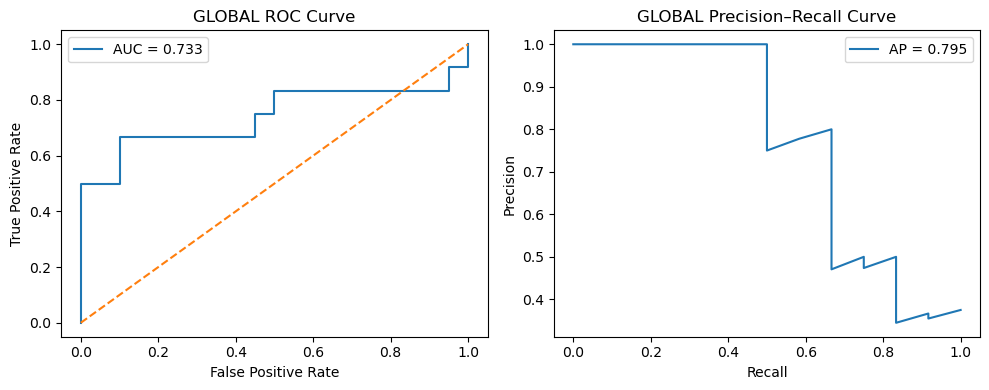

{'accuracy_per_fold': array([1.        , 0.57142857, 0.83333333, 0.83333333, 0.66666667]),
 'accuracy_mean': np.float64(0.780952380952381),
 'accuracy_std': np.float64(0.1486141574697832),
 'balanced_accuracy_per_fold': array([1.        , 0.58333333, 0.75      , 0.75      , 0.625     ]),
 'balanced_accuracy_mean': np.float64(0.7416666666666666),
 'balanced_accuracy_std': np.float64(0.1452966314513558),
 'precision_per_fold': array([1. , 0.5, 1. , 1. , 0.5]),
 'precision_mean': np.float64(0.8),
 'precision_std': np.float64(0.2449489742783178),
 'recall_per_fold': array([1.        , 0.66666667, 0.5       , 0.5       , 0.5       ]),
 'recall_mean': np.float64(0.6333333333333333),
 'recall_std': np.float64(0.19436506316151003),
 'f1_per_fold': array([1.        , 0.57142857, 0.66666667, 0.66666667, 0.5       ]),
 'f1_mean': np.float64(0.680952380952381),
 'f1_std': np.float64(0.17142857142857143),
 'roc_auc_per_fold': array([1.        , 0.66666667, 0.5       , 0.75      , 0.75      ]),
 'ro

In [38]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, penalty="l2"))
])

evaluate_binary_model_cv(pipe, X, y)


Fold 1/5
  Accuracy:           0.857
  Balanced accuracy:  0.833
  Precision:          1.000
  Recall:             0.667
  F1-score:           0.800
  ROC AUC:            1.000
  PR AUC (AvgPrec):   1.000

Fold 2/5
  Accuracy:           0.714
  Balanced accuracy:  0.708
  Precision:          0.667
  Recall:             0.667
  F1-score:           0.667
  ROC AUC:            0.750
  PR AUC (AvgPrec):   0.756

Fold 3/5
  Accuracy:           0.833
  Balanced accuracy:  0.750
  Precision:          1.000
  Recall:             0.500
  F1-score:           0.667
  ROC AUC:            0.875
  PR AUC (AvgPrec):   0.833

Fold 4/5
  Accuracy:           0.833
  Balanced accuracy:  0.750
  Precision:          1.000
  Recall:             0.500
  F1-score:           0.667
  ROC AUC:            0.875
  PR AUC (AvgPrec):   0.833

Fold 5/5
  Accuracy:           0.667
  Balanced accuracy:  0.625
  Precision:          0.500
  Recall:             0.500
  F1-score:           0.500
  ROC AUC:            0.75

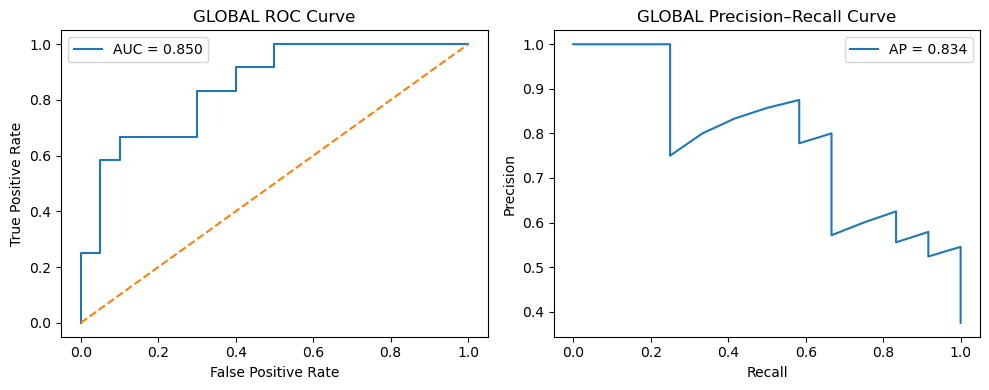

{'accuracy_per_fold': array([0.85714286, 0.71428571, 0.83333333, 0.83333333, 0.66666667]),
 'accuracy_mean': np.float64(0.780952380952381),
 'accuracy_std': np.float64(0.07589227357385347),
 'balanced_accuracy_per_fold': array([0.83333333, 0.70833333, 0.75      , 0.75      , 0.625     ]),
 'balanced_accuracy_mean': np.float64(0.7333333333333333),
 'balanced_accuracy_std': np.float64(0.06770032003863298),
 'precision_per_fold': array([1.        , 0.66666667, 1.        , 1.        , 0.5       ]),
 'precision_mean': np.float64(0.8333333333333333),
 'precision_std': np.float64(0.21081851067789195),
 'recall_per_fold': array([0.66666667, 0.66666667, 0.5       , 0.5       , 0.5       ]),
 'recall_mean': np.float64(0.5666666666666667),
 'recall_std': np.float64(0.08164965809277258),
 'f1_per_fold': array([0.8       , 0.66666667, 0.66666667, 0.66666667, 0.5       ]),
 'f1_mean': np.float64(0.6599999999999999),
 'f1_std': np.float64(0.09521904571390467),
 'roc_auc_per_fold': array([1.   , 0.75 

In [33]:

rf = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=0)
evaluate_binary_model_cv(rf, X, y)


Fold 1/5
  Accuracy:           1.000
  Balanced accuracy:  1.000
  Precision:          1.000
  Recall:             1.000
  F1-score:           1.000
  ROC AUC:            1.000
  PR AUC (AvgPrec):   1.000

Fold 2/5
  Accuracy:           0.714
  Balanced accuracy:  0.708
  Precision:          0.667
  Recall:             0.667
  F1-score:           0.667
  ROC AUC:            0.833
  PR AUC (AvgPrec):   0.867

Fold 3/5
  Accuracy:           0.833
  Balanced accuracy:  0.750
  Precision:          1.000
  Recall:             0.500
  F1-score:           0.667
  ROC AUC:            0.750
  PR AUC (AvgPrec):   0.750

Fold 4/5
  Accuracy:           0.833
  Balanced accuracy:  0.750
  Precision:          1.000
  Recall:             0.500
  F1-score:           0.667
  ROC AUC:            1.000
  PR AUC (AvgPrec):   1.000

Fold 5/5
  Accuracy:           0.833
  Balanced accuracy:  0.750
  Precision:          1.000
  Recall:             0.500
  F1-score:           0.667
  ROC AUC:            0.75

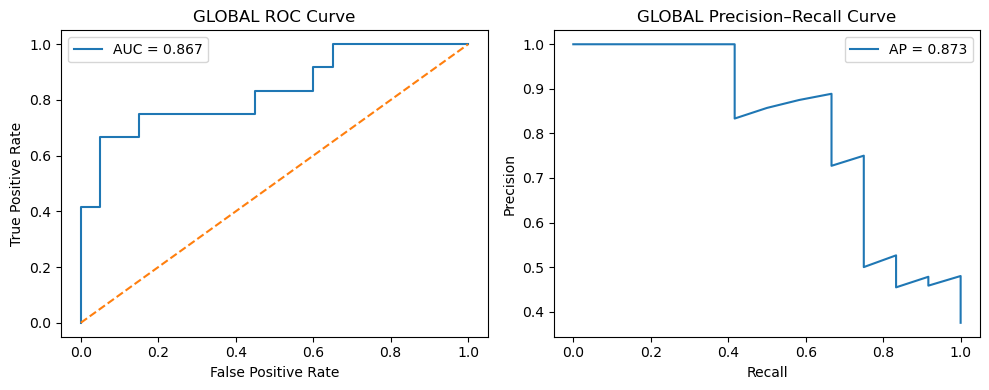

{'accuracy_per_fold': array([1.        , 0.71428571, 0.83333333, 0.83333333, 0.83333333]),
 'accuracy_mean': np.float64(0.8428571428571429),
 'accuracy_std': np.float64(0.09110060223670947),
 'balanced_accuracy_per_fold': array([1.        , 0.70833333, 0.75      , 0.75      , 0.75      ]),
 'balanced_accuracy_mean': np.float64(0.7916666666666666),
 'balanced_accuracy_std': np.float64(0.10540925533894598),
 'precision_per_fold': array([1.        , 0.66666667, 1.        , 1.        , 1.        ]),
 'precision_mean': np.float64(0.9333333333333332),
 'precision_std': np.float64(0.13333333333333336),
 'recall_per_fold': array([1.        , 0.66666667, 0.5       , 0.5       , 0.5       ]),
 'recall_mean': np.float64(0.6333333333333333),
 'recall_std': np.float64(0.19436506316151003),
 'f1_per_fold': array([1.        , 0.66666667, 0.66666667, 0.66666667, 0.66666667]),
 'f1_mean': np.float64(0.7333333333333332),
 'f1_std': np.float64(0.13333333333333336),
 'roc_auc_per_fold': array([1.        ,

In [39]:
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
)

evaluate_binary_model_cv(model, X, y)

## Testing: More features

In [40]:
import scanpy as sc

In [41]:
adata = sc.read("../data/melanoma_scRNA_processed.h5ad")

In [42]:
def compute_patient_expression_features(adata, gene_list, groupby="PatientID"):
    rows = []

    for pid, sub in adata.obs.groupby(groupby):
        # get the cells belonging to that patient
        cell_idx = sub.index
        expr_matrix = adata[cell_idx].X.toarray()

        row = {"PatientID": pid}

        # compute mean expression per gene
        for g in gene_list:
            if g in adata.var_names:
                g_idx = adata.var_names.get_loc(g)
                row[f"mean_{g}"] = expr_matrix[:, g_idx].mean()
            else:
                row[f"mean_{g}"] = 0.0

        rows.append(row)

    return pd.DataFrame(rows)

In [43]:
marker_genes = ["CD8A", "CD8B", "GZMB", "NKG7", "IL7R", "CCR7", "PDCD1", "LAG3"]
patient_expr = compute_patient_expression_features(adata, marker_genes)

/var/folders/c4/570ty6gd42v42mmcqq8z2mrc0000gn/T/ipykernel_36936/1155745612.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for pid, sub in adata.obs.groupby(groupby):


In [44]:
features = patient_features.merge(patient_expr, on="PatientID")

In [45]:
X = features.drop(columns=["PatientID", "Response"])
y = (features["Response"] == "Responder").astype(int)

In [46]:
clf = RandomForestClassifier(n_estimators=300, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)

print("RF Accuracy:", scores.mean())

RF Accuracy: 0.7857142857142857


In [47]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, penalty="l2"))
])

scores = cross_val_score(pipe, X, y, cv=5)
print("Logistic Regression accuracy:", scores.mean())

Logistic Regression accuracy: 0.7523809523809524


In [48]:
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
)

scores = cross_val_score(model, X, y, cv=5)
print("XGBoost accuracy:", scores.mean())

XGBoost accuracy: 0.7523809523809525


### More metrics


Fold 1/5
  Accuracy:           1.000
  Balanced accuracy:  1.000
  Precision:          1.000
  Recall:             1.000
  F1-score:           1.000
  ROC AUC:            1.000
  PR AUC (AvgPrec):   1.000

Fold 2/5
  Accuracy:           0.429
  Balanced accuracy:  0.458
  Precision:          0.400
  Recall:             0.667
  F1-score:           0.500
  ROC AUC:            0.667
  PR AUC (AvgPrec):   0.810

Fold 3/5
  Accuracy:           0.833
  Balanced accuracy:  0.750
  Precision:          1.000
  Recall:             0.500
  F1-score:           0.667
  ROC AUC:            0.750
  PR AUC (AvgPrec):   0.750

Fold 4/5
  Accuracy:           0.833
  Balanced accuracy:  0.750
  Precision:          1.000
  Recall:             0.500
  F1-score:           0.667
  ROC AUC:            1.000
  PR AUC (AvgPrec):   1.000

Fold 5/5
  Accuracy:           0.667
  Balanced accuracy:  0.625
  Precision:          0.500
  Recall:             0.500
  F1-score:           0.500
  ROC AUC:            0.75

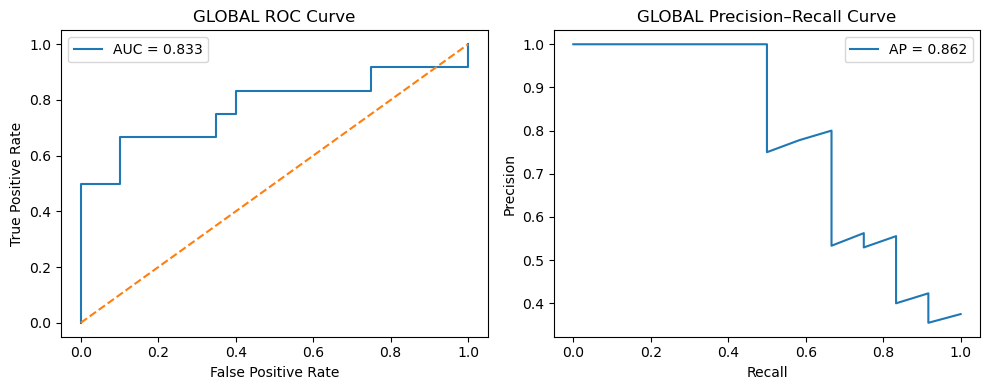

{'accuracy_per_fold': array([1.        , 0.42857143, 0.83333333, 0.83333333, 0.66666667]),
 'accuracy_mean': np.float64(0.7523809523809524),
 'accuracy_std': np.float64(0.19319488357238854),
 'balanced_accuracy_per_fold': array([1.        , 0.45833333, 0.75      , 0.75      , 0.625     ]),
 'balanced_accuracy_mean': np.float64(0.7166666666666666),
 'balanced_accuracy_std': np.float64(0.17756063127218763),
 'precision_per_fold': array([1. , 0.4, 1. , 1. , 0.5]),
 'precision_mean': np.float64(0.78),
 'precision_std': np.float64(0.2712931993250107),
 'recall_per_fold': array([1.        , 0.66666667, 0.5       , 0.5       , 0.5       ]),
 'recall_mean': np.float64(0.6333333333333333),
 'recall_std': np.float64(0.19436506316151003),
 'f1_per_fold': array([1.        , 0.5       , 0.66666667, 0.66666667, 0.5       ]),
 'f1_mean': np.float64(0.6666666666666666),
 'f1_std': np.float64(0.18257418583505536),
 'roc_auc_per_fold': array([1.        , 0.66666667, 0.75      , 1.        , 0.75      ]),

In [49]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, penalty="l2"))
])

evaluate_binary_model_cv(pipe, X, y)


Fold 1/5
  Accuracy:           1.000
  Balanced accuracy:  1.000
  Precision:          1.000
  Recall:             1.000
  F1-score:           1.000
  ROC AUC:            1.000
  PR AUC (AvgPrec):   1.000

Fold 2/5
  Accuracy:           0.714
  Balanced accuracy:  0.708
  Precision:          0.667
  Recall:             0.667
  F1-score:           0.667
  ROC AUC:            0.917
  PR AUC (AvgPrec):   0.917

Fold 3/5
  Accuracy:           0.833
  Balanced accuracy:  0.750
  Precision:          1.000
  Recall:             0.500
  F1-score:           0.667
  ROC AUC:            0.688
  PR AUC (AvgPrec):   0.700

Fold 4/5
  Accuracy:           0.833
  Balanced accuracy:  0.750
  Precision:          1.000
  Recall:             0.500
  F1-score:           0.667
  ROC AUC:            1.000
  PR AUC (AvgPrec):   1.000

Fold 5/5
  Accuracy:           0.667
  Balanced accuracy:  0.625
  Precision:          0.500
  Recall:             0.500
  F1-score:           0.500
  ROC AUC:            0.75

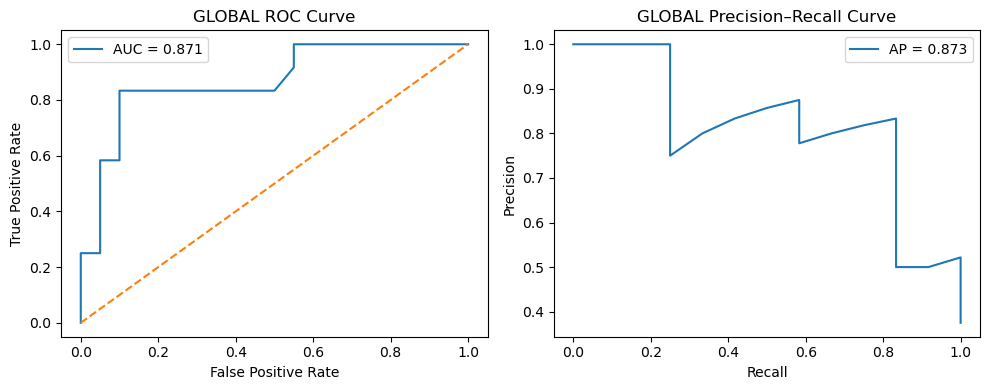

{'accuracy_per_fold': array([1.        , 0.71428571, 0.83333333, 0.83333333, 0.66666667]),
 'accuracy_mean': np.float64(0.8095238095238096),
 'accuracy_std': np.float64(0.1156662647761059),
 'balanced_accuracy_per_fold': array([1.        , 0.70833333, 0.75      , 0.75      , 0.625     ]),
 'balanced_accuracy_mean': np.float64(0.7666666666666666),
 'balanced_accuracy_std': np.float64(0.12527746981977425),
 'precision_per_fold': array([1.        , 0.66666667, 1.        , 1.        , 0.5       ]),
 'precision_mean': np.float64(0.8333333333333333),
 'precision_std': np.float64(0.21081851067789195),
 'recall_per_fold': array([1.        , 0.66666667, 0.5       , 0.5       , 0.5       ]),
 'recall_mean': np.float64(0.6333333333333333),
 'recall_std': np.float64(0.19436506316151003),
 'f1_per_fold': array([1.        , 0.66666667, 0.66666667, 0.66666667, 0.5       ]),
 'f1_mean': np.float64(0.7),
 'f1_std': np.float64(0.1632993161855452),
 'roc_auc_per_fold': array([1.        , 0.91666667, 0.68

In [50]:

rf = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=0)
evaluate_binary_model_cv(rf, X, y)


Fold 1/5
  Accuracy:           1.000
  Balanced accuracy:  1.000
  Precision:          1.000
  Recall:             1.000
  F1-score:           1.000
  ROC AUC:            1.000
  PR AUC (AvgPrec):   1.000

Fold 2/5
  Accuracy:           0.714
  Balanced accuracy:  0.708
  Precision:          0.667
  Recall:             0.667
  F1-score:           0.667
  ROC AUC:            0.917
  PR AUC (AvgPrec):   0.917

Fold 3/5
  Accuracy:           0.667
  Balanced accuracy:  0.500
  Precision:          0.000
  Recall:             0.000
  F1-score:           0.000
  ROC AUC:            0.875
  PR AUC (AvgPrec):   0.833

Fold 4/5
  Accuracy:           1.000
  Balanced accuracy:  1.000
  Precision:          1.000
  Recall:             1.000
  F1-score:           1.000
  ROC AUC:            1.000
  PR AUC (AvgPrec):   1.000

Fold 5/5
  Accuracy:           0.667
  Balanced accuracy:  0.625
  Precision:          0.500
  Recall:             0.500
  F1-score:           0.500
  ROC AUC:            0.62

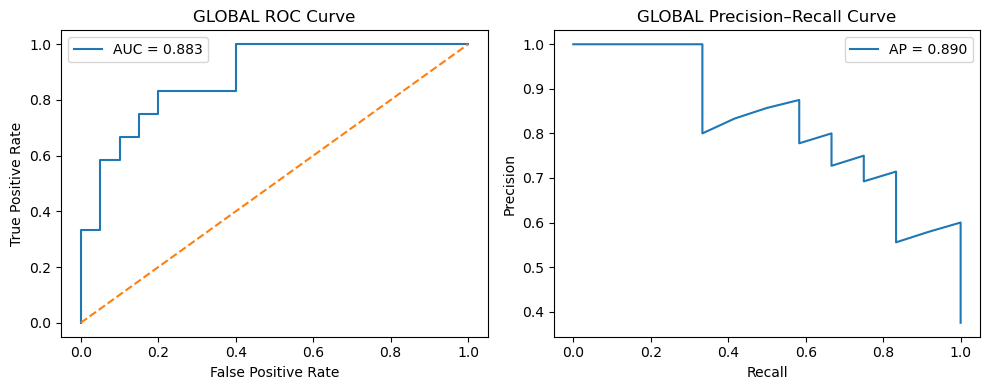

{'accuracy_per_fold': array([1.        , 0.71428571, 0.66666667, 1.        , 0.66666667]),
 'accuracy_mean': np.float64(0.8095238095238095),
 'accuracy_std': np.float64(0.15649215928719032),
 'balanced_accuracy_per_fold': array([1.        , 0.70833333, 0.5       , 1.        , 0.625     ]),
 'balanced_accuracy_mean': np.float64(0.7666666666666666),
 'balanced_accuracy_std': np.float64(0.20172864061517007),
 'precision_per_fold': array([1.        , 0.66666667, 0.        , 1.        , 0.5       ]),
 'precision_mean': np.float64(0.6333333333333333),
 'precision_std': np.float64(0.3711842908553348),
 'recall_per_fold': array([1.        , 0.66666667, 0.        , 1.        , 0.5       ]),
 'recall_mean': np.float64(0.6333333333333333),
 'recall_std': np.float64(0.3711842908553348),
 'f1_per_fold': array([1.        , 0.66666667, 0.        , 1.        , 0.5       ]),
 'f1_mean': np.float64(0.6333333333333333),
 'f1_std': np.float64(0.3711842908553348),
 'roc_auc_per_fold': array([1.        , 0.

In [51]:
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
)

evaluate_binary_model_cv(model, X, y)